In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#In MLP first layer is linear layer
#Following layers are for non-linearity

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
#build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]  * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
#MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)* (5/3)*((n_embd * block_size)**0.5) 
#to bring hpreact closer to 0, so we don't have 1 and -1 after tanh calc
#5/3 is the emperical gain for tanh activation to keep uniform distribution
#So we multiply weights by gain to maintain std of 1 for the activation output

#b1 = torch.randn(n_hidden,                        generator = g)* 0.01 #same reason as above, tanh at -1 and 1 means that we are not learning from backprop
#this bias is useless because you subtract bnmean from activation input
#this bias is not needed when using batch normalization

W2 = torch.randn((n_hidden, vocab_size),          generator = g)* 0.01 #to make logits small to reduce the loss for first forward pass
b2 = torch.randn(vocab_size,                      generator = g)* 0   #bias of 0 at initialization

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias
    #normalize hpreact to maintain unit gaussian of 1
    #bnbias and bngain allow the NN to decide whether the hpreact should have a unit guassian or not(sharp or more spread out beak) after initializaton

    with torch.no_grad():
        bnmean_running = 0.999 *bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: #print once a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.1080
  20000/ 200000: 2.7056
  30000/ 200000: 2.1581
  40000/ 200000: 2.3510
  50000/ 200000: 1.9673
  60000/ 200000: 2.2058
  70000/ 200000: 2.4311
  80000/ 200000: 2.6161
  90000/ 200000: 2.2592
 100000/ 200000: 2.3973
 110000/ 200000: 2.4511
 120000/ 200000: 1.7488
 130000/ 200000: 2.1158
 140000/ 200000: 2.4020
 150000/ 200000: 2.1161
 160000/ 200000: 2.0824
 170000/ 200000: 2.3950
 180000/ 200000: 2.1838
 190000/ 200000: 2.1770


**Analyzing first pass**

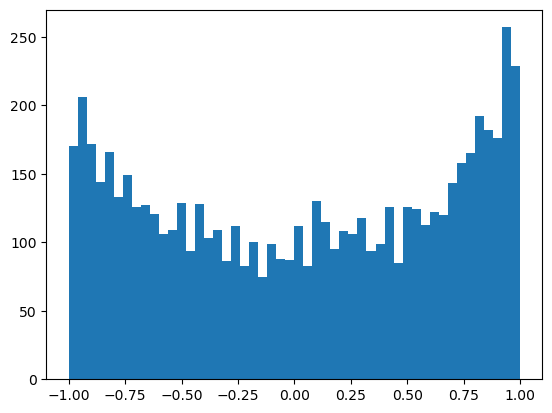

In [85]:
plt.hist(h.view(-1).tolist(), 50);
#tanh is -1 to 1 curve...squashes extremes to 1 and -1
#having tanh equal to 1 and -1 means there is no slope to differentiate over
#tanh of 1 and -1 means the backprogropogation through tanh is inactive and the gradient simply passes through\
#that means the NN is not learning where tanh is 1 or -1

#just reducing intial weights can reduce number of tanh closer to 1 and -1

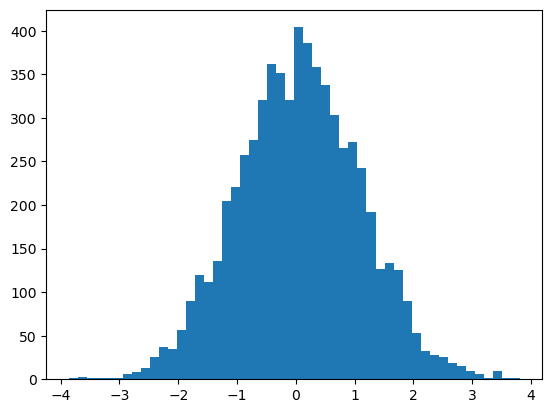

In [86]:
plt.hist(hpreact.view(-1).tolist(), 50);
#preactivations feeding into tanh, expected to be extreme values

#just reducing intial weights can reduce extreme values

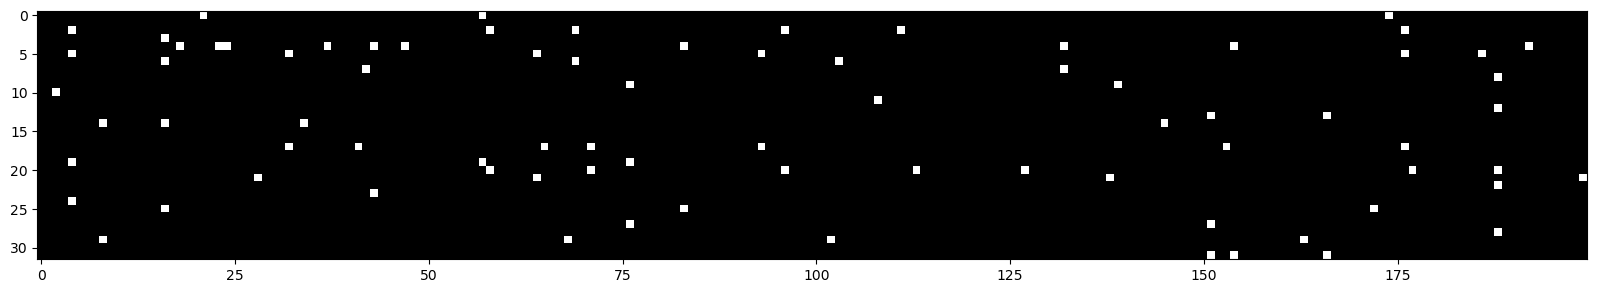

In [87]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest') #white is true. more white means gradient just passes thru
# a column of white would mean dead neuron so its not responding to the examples provided. We don't have a column of white here but still too much white

#white is gone after reducing initial weights

In [44]:
#initial probability after first forward pass should be uniform
#so instead of loss being 27 at the first forward pass it should be closer to 3.29
-torch.tensor(1/27).log()

tensor(3.2958)

**After fixing weight initialization**

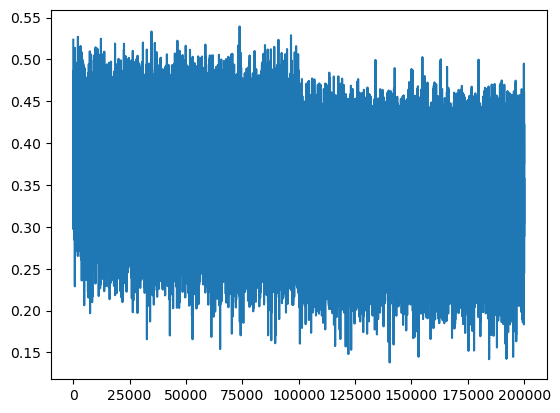

In [16]:
plt.plot(lossi)
#since first pass loss is improved, the curve is not intense for first few iterations

**Before fixing weight initialization**

In [42]:
@torch.no_grad()  #disables gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 
            'val': (Xdev, Ydev), 
            'test': (Xte, Yte)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim = True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1191043853759766
val 2.1609528064727783


**After batch-normalization**

In [9]:
@torch.no_grad()  #disables gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 
            'val': (Xdev, Ydev), 
            'test': (Xte, Yte)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    #hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim = True) + bnbias
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias
    #calibrated the batch norm during the training itself by calculating _running. This is gutting the variability associated since the training was done with mini batches
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.1734328269958496
val 2.187385082244873


**PYTORCHIFYING THE CODE**

In [47]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) #/fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #gain
        self.beta = torch.zeros(dim) #bias
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True) #batch mean
            xvar = x.var(0, keepdim = True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma*xhat + self.beta
            
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []       

In [48]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].gamma *= 0.1 #since last layer is batch normalized
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of total parameters
for p in parameters:
    p.requires_grad = True

47551


In [49]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #take out after debug
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 1.0 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 1000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        #how great are the updates compared to the values
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break #to look at initial first pass

      0/ 200000:3.2870
   1000/ 200000:2.3263


In [55]:
#5/3 is a good activation gain, greater gain will lead to sharp peaks at the edge and then smaller gains will lead to sharp peaks in the center

layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 3.91%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.53%
layer 8 (      Tanh): mean -0.02, std 0.63, saturated: 3.09%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 2.69%
layer 14 (      Tanh): mean +0.02, std 0.64, saturated: 3.34%


Text(0.5, 1.0, 'activation distribution')

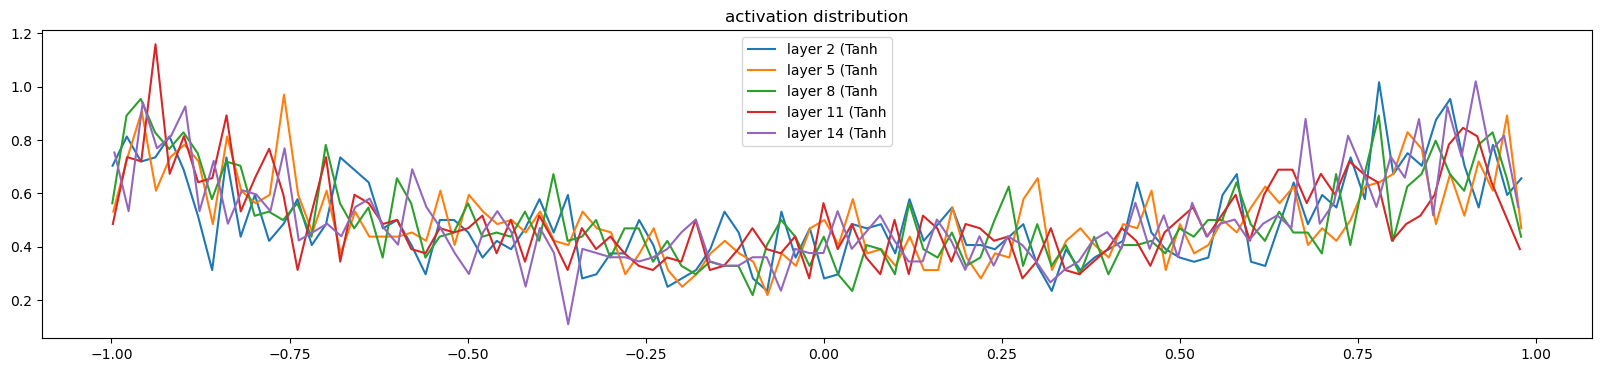

In [50]:
#visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.081714e-03
layer 5 (      Tanh): mean +0.000000, std 3.513450e-03
layer 8 (      Tanh): mean -0.000000, std 3.458262e-03
layer 11 (      Tanh): mean -0.000000, std 3.407232e-03
layer 14 (      Tanh): mean +0.000000, std 3.295503e-03


Text(0.5, 1.0, 'gradient distribution')

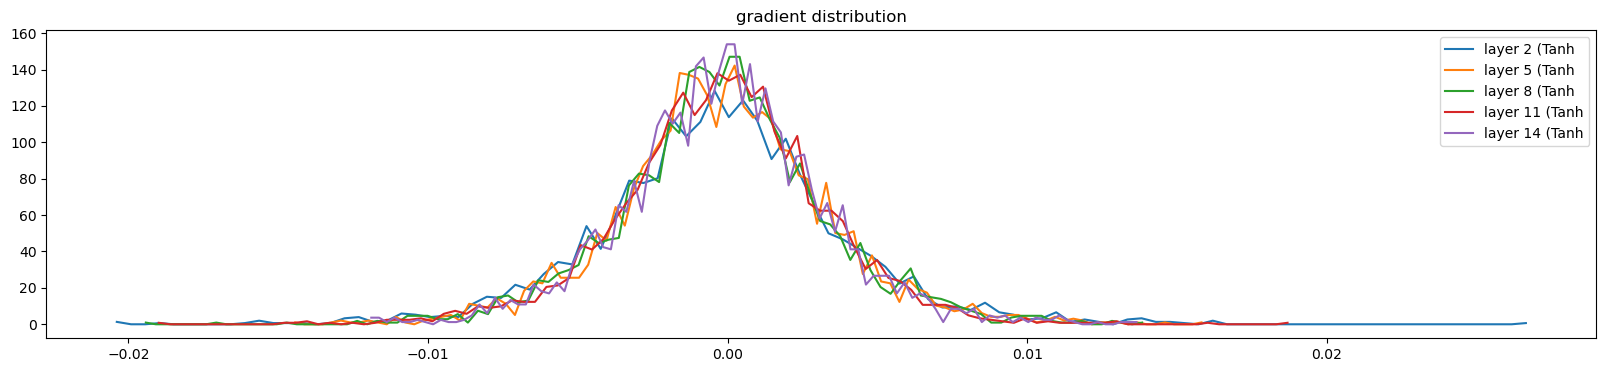

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.340184e-03 | grad:data ratio 8.083632e-03
weight  (30, 100) | mean +0.000061 | std 2.610462e-03 | grad:data ratio 2.540099e-03
weight (100, 100) | mean -0.000013 | std 1.353516e-03 | grad:data ratio 1.356912e-03
weight (100, 100) | mean -0.000005 | std 1.178780e-03 | grad:data ratio 1.169536e-03
weight (100, 100) | mean -0.000005 | std 1.124870e-03 | grad:data ratio 1.120830e-03
weight (100, 100) | mean +0.000006 | std 1.150512e-03 | grad:data ratio 1.145342e-03
weight  (100, 27) | mean -0.000025 | std 2.196449e-03 | grad:data ratio 2.218106e-03


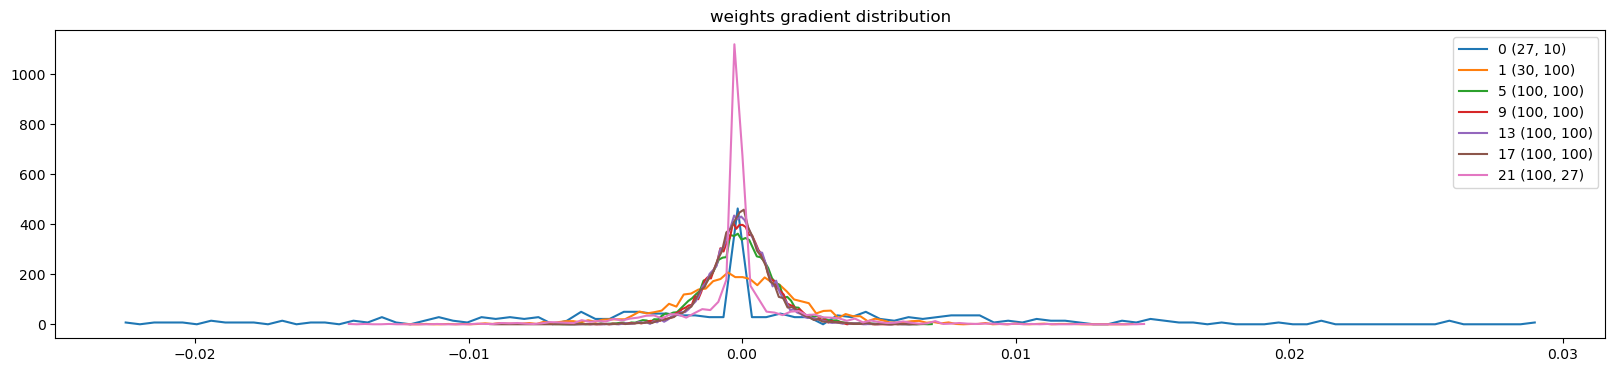

In [52]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [44]:
#this is to get a sense of the learning rate
#we should be >1e-3

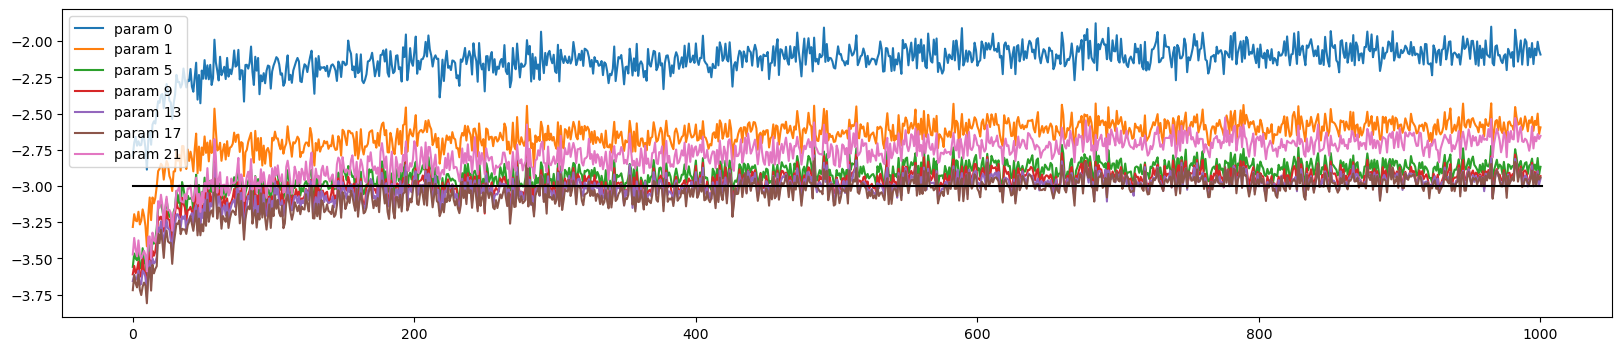

In [53]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#Summary
1. Batch Normalization (Stablize deep neural network)
2. Pytorchify code 
3. Forward Pass stats